In [2]:
import pandas as pd
import numpy as np
import pickle
import json
from copy import deepcopy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from gensim.models import word2vec
from gensim import models
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import csv
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import recall_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data

In [ ]:
## Not in use
# product_org = pd.DataFrame(df_raw)
# products=deepcopy(product_org)
# products['brand_id']=products['Brand'].apply(lambda x: x['Id'])
# products['brand_name']=products['Brand'].apply(lambda x: x['Name'])
# products['rec_cnt']=products['ReviewStatistics'].apply(lambda x: x['RecommendedCount'])
# products['avg_rating']=products['ReviewStatistics'].apply(lambda x: x['AverageOverallRating'])
# products['helpful_cnt']=products['ReviewStatistics'].apply(lambda x: x['HelpfulVoteCount'])
# products.head()

In [ ]:
# def product_parser(product):
#     agg = dict()
#     fields = ['brand_id', 'brand_name','product_id','Name','CategoryId', 'Description', 'rec_cnt', 'avg_rating','helpful_cnt','TotalReviewCount']
#     for field in fields:
#         value = product.get(field, None)
#         try:
#             agg[field] = value

#         except:
#             agg[field] = None
#     return agg

In [ ]:
# pd.DataFrame(product_parser(products)).to_pickle('product_table.pickle')
# df1=pd.read_pickle('reviewlist_all.pickle')
# df1_org=pd.DataFrame(df1)

In [ ]:
# def review_parser(review):
#     # Reference variables
#     agg = dict()
#     fields = ['AuthorId','IsFeatured','IsRatingsOnly','IsRecommended', 'product_id', 'Rating', 'ReviewText','isemployee','freeproduct','Helpfulness','Title']
#     for field in fields:
#         value = review.get(field, None)
#         #value = product.__dict__.get(field, None)

#         try:
#             agg[field] = value
#             #agg[field] = unicode(value).encode('ascii', errors='ignore') if value is not None else None

#         except:
#             agg[field] = None
#     return agg

In [ ]:
# with open('reviewlist_all.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     data = pickle.load(f)

In [ ]:
# review_i = pd.DataFrame([i for i in data if 'IncentivizedReview' in i['ContextDataValues']])
# review_i['isemployee']=review_i['ContextDataValues'].apply(lambda x: x['StaffContext']['Value'])
# review_i['freeproduct']=review_i['ContextDataValues'].apply(lambda x: x['IncentivizedReview']['Value'])
# reviews=pd.DataFrame(review_parser(review_i))
# reviews.to_pickle('review_table.pickle')

In [3]:
new=pd.read_pickle('reviewdata_sub.pickle')

In [4]:
col=list(new.columns)

In [5]:
col

['AdditionalFields.sociallockup.Id',
 'AdditionalFields.sociallockup.Label',
 'AdditionalFields.sociallockup.Value',
 'AdditionalFieldsOrder',
 'AuthorId',
 'Badges.Expert.BadgeType',
 'Badges.Expert.ContentType',
 'Badges.Expert.Id',
 'Badges.IncentivizedReviewBadge.BadgeType',
 'Badges.IncentivizedReviewBadge.ContentType',
 'Badges.IncentivizedReviewBadge.Id',
 'Badges.Staff.BadgeType',
 'Badges.Staff.ContentType',
 'Badges.Staff.Id',
 'Badges.StaffContextBadge.BadgeType',
 'Badges.StaffContextBadge.ContentType',
 'Badges.StaffContextBadge.Id',
 'Badges.beautyInsider.BadgeType',
 'Badges.beautyInsider.ContentType',
 'Badges.beautyInsider.Id',
 'Badges.top10Contributor.BadgeType',
 'Badges.top10Contributor.ContentType',
 'Badges.top10Contributor.Id',
 'Badges.top1Contributor.BadgeType',
 'Badges.top1Contributor.ContentType',
 'Badges.top1Contributor.Id',
 'Badges.top25Contributor.BadgeType',
 'Badges.top25Contributor.ContentType',
 'Badges.top25Contributor.Id',
 'Badges.top50Contribut

In [6]:
new.shape

(110292, 123)

## Parse

In [7]:
def review_parser_new(review):
    # Reference variables
    agg = dict()
    fields = ['AuthorId','IsFeatured','IsRatingsOnly','IsRecommended', 'Rating', 'Title','ReviewText',
              'ContextDataValues.StaffContext.Value','ContextDataValues.IncentivizedReview.Value',
              'ContextDataValues.age.Value','ContextDataValues.beautyInsider.Value','Helpfulness','product_id',
             'productPrice','']
    for field in fields:
        value = review.get(field, None)
        #value = product.__dict__.get(field, None)

        try:
            agg[field] = value
            #agg[field] = unicode(value).encode('ascii', errors='ignore') if value is not None else None

        except:
            agg[field] = None
    return agg

In [8]:
reviews_new=pd.DataFrame(review_parser_new(new))

In [9]:
reviews_new['incentivized']=0
reviews_new.loc[(reviews_new['ContextDataValues.IncentivizedReview.Value']=='true')|(reviews_new['ContextDataValues.StaffContext.Value']=='true'),'incentivized']=1

In [10]:
reviews_new['age']=reviews_new['ContextDataValues.age.Value'].fillna('unknow')

In [11]:
reviews_new['vib']=reviews_new['ContextDataValues.beautyInsider.Value'].fillna('unknow')

In [12]:
reviews_new['incentivized']=0
reviews_new.loc[(reviews_new['ContextDataValues.StaffContext.Value']=='true')|(reviews_new['ContextDataValues.IncentivizedReview.Value']=='true'),'incentivized']=1


In [13]:
reviews_new.reset_index(inplace=True)

In [14]:
reviews_new=reviews_new[['index', 'AuthorId', 'IsFeatured', 'IsRatingsOnly', 'IsRecommended',
       'Rating', 'Title', 'ReviewText', 'Helpfulness', 'product_id', 'productPrice', 'incentivized', 'age','vib']]

In [15]:
reviews_new.columns=['review_id', 'AuthorId', 'IsFeatured', 'IsRatingsOnly', 'IsRecommended',
       'Rating', 'Title', 'ReviewText', 'Helpfulness', 'product_id',
       'productPrice', 'incentivized', 'age', 'vib']

In [16]:
reviews_new.incentivized.value_counts()

0    102690
1      7602
Name: incentivized, dtype: int64

### Review analyze

In [17]:
df=pd.DataFrame(reviews_new[['ReviewText','incentivized','review_id']])

In [18]:
#sentence tokenizer for each review
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs'])
tokenizer = PunktSentenceTokenizer(punkt_param)
df['review_sentences'] = df['ReviewText'].map(lambda text: tokenizer.tokenize(text))

In [19]:
df.head()

,ReviewText,incentivized,review_id,review_sentences
0,I tried ItCosmetics about a year ago and loved...,0,881,[I tried ItCosmetics about a year ago and love...
1,I've purchased hundreds of items from Sephora ...,0,888,[I've purchased hundreds of items from Sephora...
2,I'm obsessed with taking care of my skin and I...,0,894,[I'm obsessed with taking care of my skin and ...
3,"This is the only ""foundation"" ive ever bought ...",0,897,"[This is the only ""foundation"" ive ever bought..."
4,I have to use 6 blottung sheets after using this,0,901,[I have to use 6 blottung sheets after using t...


In [ ]:
df.to_csv('review_table.csv')

In [20]:
# split long sentences in review_sentences
def split_long_sentence(sentences):
    shorter_sentences = []
    for sentence in sentences:
        if len(sentence) >= 50:
            sub_sentences = re.split('&|!|;|and|,|~|but|\.|so i|\s-\s|\(|\)', sentence.lower())
            sub_sentences = [s.strip() for s in sub_sentences]
            shorter_sentences += sub_sentences
        else:
            shorter_sentences.append(sentence.lower())
    shorter_sentences = filter(lambda s: len(s) > 13 
                               and not s.startswith('i have')
                               and not s.startswith('i also have')
                               and not s.startswith('i\'m')
                               and not s.startswith('i had')
                               and not s.startswith('i\'ve been')
                               and not s.startswith('i thought')
                               and not s.startswith('i was ')
                               and not s.startswith('i use ')
                               and not s.startswith('i used to')
                               and not s.startswith('if you have')
                               and not s.startswith('i suffer')
                               and not ('i do have' in s)
                               and not ('looking for' in s)
                               and not ('i purchase' in s)
                               and not ('i bought' in s)
                               , shorter_sentences)
    return list(shorter_sentences)

In [22]:
#Generate table of all the sentences with review_ids
review_ids = []
review_sentences = []
for review in df.as_matrix():
    curr_review_id = review[2]
    curr_review_sentences = review[-1]
    
    # Divide long sentences even longer if possible!
    shorter_sentences = split_long_sentence(curr_review_sentences)
    
    review_ids += [curr_review_id] * len(shorter_sentences)
    review_sentences += shorter_sentences
    
df_review_sentences = pd.DataFrame({'review_id': review_ids, 'sentence': review_sentences})
df_review_sentences.sample(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


,review_id,sentence
96132,39222,it's wonderful to awaken the senses
575946,251323,really enjoyed it
286402,129967,i can't believe i've gone so long without this...
461858,210479,a lovely combination
493675,217860,even though i only had the finest of lines
506506,224399,usually clinique moisture surge
596162,261118,i can't say that it makes my makeup last that ...
393710,185869,this isn't full coverage.
820052,367937,it's hard to control the amount you put on as ...
484816,216269,my skin was greasy


In [23]:
df_review_sentences.shape

(837827, 2)

In [24]:
## Tokenize sentences
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [25]:
tokenizer_regex = re.compile(r"[\s]")
def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    tokens = [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]
    filtered_tokens = tokens# filter(lambda tok: tok not in stop_words, tokens)
    return list(filtered_tokens)

In [26]:
def get_word_weights(docs):
    tfidf = TfidfVectorizer(stop_words=frozenset(stop_words), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
    tfidf.fit(docs)
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf,
                                    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight
    
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
get_word_weights(test_docs2)

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'bird': 1.8472978603872037,
             'blah': 2.252762968495368,
             'cat': 1.5596157879354227,
             'dog': 1.8472978603872037,
             'fish': 1.5596157879354227,
             'harper': 2.252762968495368,
             'tata': 2.252762968495368})

In [27]:
tfidf = TfidfVectorizer(stop_words=frozenset(stop_words), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
tfidf.fit(test_docs2)
tfidf.idf_

array([1.84729786, 2.25276297, 1.55961579, 1.84729786, 1.55961579,
       2.25276297, 2.25276297])

In [28]:
tfidf.vocabulary_.items()

dict_items([('dog', 3), ('cat', 2), ('fish', 4), ('bird', 0), ('blah', 1), ('tata', 6), ('harper', 5)])

In [29]:
w2v = models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)
#model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=4,sg=1)

In [ ]:
#w2v.most_similar(positive=['wrinkle'], topn=25)

In [30]:
'review' in w2v.vocab

True

In [31]:
df_review_sentences['tokenized_words'] = df_review_sentences['sentence'].map(lambda sentence: tokenize(sentence))
df_review_sentences['tokenized_filtered_words'] = df_review_sentences['tokenized_words'].map(
    lambda tokenized_words: [word for word in tokenized_words if word in w2v.vocab])
df_review_sentences['tokenized_filtered_words_length'] = df_review_sentences['tokenized_filtered_words'].map(
    lambda tokenized_filtered_words: len(tokenized_filtered_words))

In [32]:
df_review_sentences = df_review_sentences[df_review_sentences.tokenized_filtered_words_length > 3]
df_review_sentences = df_review_sentences.reset_index()
word2weight = get_word_weights(df_review_sentences['sentence'])

In [33]:
df_review_sentences.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length
0,0,881,i tried itcosmetics about a year ago,"[i, tried, itcosmetics, about, a, year, ago]","[i, tried, about, year, ago]",5
1,2,881,bye bye pore powder,"[bye, bye, pore, powder]","[bye, bye, pore, powder]",4
2,3,881,of course i had to try the cc cream,"[of, course, i, had, to, try, the, cc, cream]","[course, i, had, try, the, cc, cream]",7
3,4,881,just as with all other itcosmetics products i ...,"[just, as, with, all, other, itcosmetics, prod...","[just, as, with, all, other, products, i, love...",9
4,5,881,during the summer i like having something ligh...,"[during, the, summer, i, like, having, somethi...","[during, the, summer, i, like, having, somethi...",15


In [35]:
def get_docs_vocab(docs):
    count_vectorizer = CountVectorizer(ngram_range=(1,1),  
                                       stop_words=frozenset(stop_words), 
                                       tokenizer=tokenize)
    count_vectorizer.fit_transform(docs)
    vocab = count_vectorizer.vocabulary_.keys()
    return vocab
get_docs_vocab(['cat mouse dog', 'mouse dog'])

dict_keys(['cat', 'mouse', 'dog'])

In [36]:
def get_pos_weight(tokens):
    word_pos = nltk.pos_tag(tokens)
    word_to_weight = {}
    for word, pos in word_pos:
        if pos.startswith('JJ') | pos.startswith('RB'):
            word_to_weight[word] = 2 # adjective or adverb
        elif (pos == 'VBD') | (pos == 'VBG') | (pos == 'VBN'):
            word_to_weight[word] = 1.3 # verb
#         elif (pos == 'NN'):
#              word_to_weight[word] = 1.1 # noun
        else: 
            word_to_weight[word] = 1
    return word_to_weight

In [37]:
import nltk
test_pos = defaultdict( list )
test_words = ['refreshed', 'tingling', 'tried', 'redness', 'dried', 'dry', 'added',
              'eczema', 'sensitive', 'tight', 'recommend', 'pick', 'matte', 'removed', 'slippery',
              'irritated', 'pleased', 'feels', 'five', 'forever', 'milky', 'hydrated', 'favorite', 'didn\'t']
test_words_pos = nltk.pos_tag(test_words)
for word, pos in test_words_pos:
    test_pos[pos].append(word)
#get_pos_weight(test_words)
print(test_pos)

defaultdict(<class 'list'>, {'VBN': ['refreshed', 'irritated', 'hydrated'], 'VBG': ['tingling'], 'JJ': ['tried', 'dry', 'sensitive', 'tight', 'pleased', 'favorite'], 'NN': ['redness', 'recommend', 'pick', 'matte', "didn't"], 'VBD': ['dried', 'added', 'removed'], 'RB': ['eczema', 'slippery', 'forever', 'milky'], 'NNS': ['feels'], 'CD': ['five']})


In [38]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Minmin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [39]:
docs_vocab = get_docs_vocab(df_review_sentences['sentence'])


In [41]:
pos_weights = get_pos_weight(list(docs_vocab))

In [42]:
def word2vec_pos_weight(tokenized_filtered_words):
    return np.mean([w2v[w] * pos_weights.get(w, 1) * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

In [43]:
def word2vec_tfidf(tokenized_filtered_words):
    return np.mean([w2v[w] * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

In [44]:
df_review_sentences['word2vec'] = df_review_sentences['tokenized_filtered_words'].apply(
    # lambda tokenized_filtered_words: np.mean(w2v[tokenized_filtered_words], axis=0)
    #lambda tokenized_filtered_words: word2vec_tfidf(tokenized_filtered_words)
    lambda tokenized_filtered_words: word2vec_pos_weight(tokenized_filtered_words)
)

In [45]:
sentence_word_vectors = np.array(df_review_sentences['word2vec'].values.tolist())
sentence_word_vectors.shape

(739460, 300)

In [425]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 30
    inertia_values = []
    for cluster_count in range(1, max_number_clusters+1):
        print('fitting cluster ', cluster_count)
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)
    plt.savefig('kmeans_inertia.png', dpi=500)

fitting cluster  1
fitting cluster  2
fitting cluster  3
fitting cluster  4
fitting cluster  5
fitting cluster  6
fitting cluster  7
fitting cluster  8
fitting cluster  9
fitting cluster  10
fitting cluster  11
fitting cluster  12
fitting cluster  13
fitting cluster  14
fitting cluster  15
fitting cluster  16
fitting cluster  17
fitting cluster  18
fitting cluster  19
fitting cluster  20
fitting cluster  21
fitting cluster  22
fitting cluster  23
fitting cluster  24
fitting cluster  25
fitting cluster  26
fitting cluster  27
fitting cluster  28
fitting cluster  29
fitting cluster  30


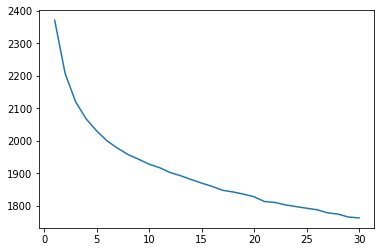

In [426]:
plot_kmeans_inertia(sentence_word_vectors_truncated_sub)

## Kmeans

In [46]:
number_sentences = sentence_word_vectors.shape[0]
df_review_sentences_truncated = df_review_sentences.iloc[0:number_sentences, :]
sentence_word_vectors_truncated = sentence_word_vectors[0:number_sentences, :]
sentence_word_vectors_truncated = normalize(sentence_word_vectors_truncated)
sentence_word_vectors_truncated.shape

(739460, 300)

In [47]:
cluster_count = 25
km = MiniBatchKMeans(n_clusters=cluster_count,random_state=1)
#km = KMeans(n_clusters=cluster_count,random_state=3)
review_word2vec_clusters = km.fit_predict(sentence_word_vectors_truncated)
len(review_word2vec_clusters)

739460

In [48]:
df_sentence_cluster = pd.DataFrame({})
cluster_columns = ['feat_' + str(i) for i in range(0, cluster_count)]
for i in range(0, cluster_count):
    cluster_column = cluster_columns[i]
    df_sentence_cluster[cluster_column] = (review_word2vec_clusters == i).astype(int)
    
df_sentence = pd.concat([df_review_sentences, df_sentence_cluster], axis=1)
df_sentence[df_sentence['feat_0'] == 1].head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24
174,203,981,no matter what primer,"[no, matter, what, primer]","[no, matter, what, primer]",4,"[1.6564009, 0.1348876, 1.2009382, -0.14266068,...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
438,503,1085,pilling issues even with a primer,"[pilling, issues, even, with, a, primer]","[pilling, issues, even, with, primer]",5,"[0.46836734, 2.204165, -1.3638164, 0.13145824,...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
607,688,1159,tried using primer underneath,"[tried, using, primer, underneath]","[tried, using, primer, underneath]",4,"[1.5520695, 0.30630547, 0.13912174, -0.1742793...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
995,1124,1463,without moisturizer or primer,"[without, moisturizer, or, primer]","[without, moisturizer, or, primer]",4,"[1.1174576, 0.40472728, 0.34562433, 0.48568708...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
1257,1416,1617,even with a primer/setting powder,"[even, with, a, primer, setting, powder]","[even, with, primer, setting, powder]",5,"[0.28232974, 0.88873976, 0.6070827, -0.0291965...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df_sentence_all = pd.merge(df_sentence, df, on='review_id', how='left')
df_sentence_all.head(2)

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,ReviewText,incentivized,review_sentences
0,0,881,i tried itcosmetics about a year ago,"[i, tried, itcosmetics, about, a, year, ago]","[i, tried, about, year, ago]",5,"[0.5861834, 0.23684621, 1.3089736, 0.16396539,...",0,0,0,...,0,0,1,0,0,0,0,I tried ItCosmetics about a year ago and loved...,0,[I tried ItCosmetics about a year ago and love...
1,2,881,bye bye pore powder,"[bye, bye, pore, powder]","[bye, bye, pore, powder]",4,"[0.55354995, 1.2629566, 1.2497354, -2.2420397,...",0,0,0,...,0,0,0,0,0,0,0,I tried ItCosmetics about a year ago and loved...,0,[I tried ItCosmetics about a year ago and love...


In [50]:
ratio=[]
for i in range(25):
    a=df_sentence_all[df_sentence_all['feat_'+str(i)] ==1]
    ratio.append(sum(a['incentivized'])/len(a['incentivized']))
n=np.argmax(ratio)
print(n,ratio[n])

15 0.308843680826394


In [43]:
df_sentence_all[df_sentence_all['feat_15'] == 1]['sentence'].to_csv('feature.csv')

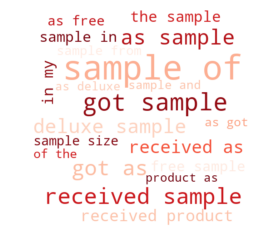

In [51]:
text=''.join(list(df_sentence_all[df_sentence_all['feat_15'] == 1]['sentence']))
wordcloud = WordCloud(width=480, height=480,background_color="white",margin=0,colormap="Reds",
                     stopwords=["samplei", "sephora",'this','i','thisi'],max_words=20).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
#plt.show()
plt.savefig('wordcloud.png', dpi=500,transparent=True)

In [52]:
from collections import Counter
c = Counter(text.split())
c.most_common(15)

[('a', 8232),
 ('sample', 5865),
 ('this', 5120),
 ('of', 3555),
 ('got', 3198),
 ('received', 3114),
 ('as', 2848),
 ('the', 1816),
 ('samplei', 1688),
 ('in', 1414),
 ('my', 1128),
 ('deluxe', 1094),
 ('from', 1071),
 ('i', 987),
 ('product', 971)]

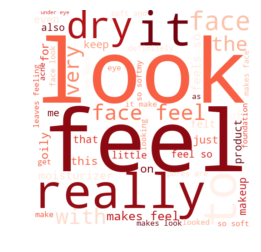

In [53]:
text=''.join(list(df_sentence_all[df_sentence_all['feat_23'] == 1]['sentence']))
wordcloud = WordCloud(width=480, height=480, margin=0,background_color="white",colormap="Reds",
                     stopwords=['was','in','skinmy','skin','my','is'],max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
#!pip3 install pyldavis
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display
from sklearn import datasets

categories = ['alt.atheism', 'comp.graphics', 'rec.sport.baseball']
ng_train = datasets.fetch_20newsgroups(subset='train', 
                                       categories=categories, 
                                       remove=('headers', 
                                               'footers', 'quotes'))

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b")

X = count_vectorizer.fit_transform(ng_train.data)
n_topics = 3
n_iter = 10
lda = LatentDirichletAllocation(n_topics=n_topics,
                                max_iter=n_iter,
                                random_state=42)
data = lda.fit_transform(X)

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.sklearn.prepare(lda, X, count_vectorizer)

# Export as a standalone HTML web page
# pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

## Classification model

### Without text feature

In [54]:
reviews_new['n_reviews']=reviews_new['review_id'].groupby(reviews_new['AuthorId']).transform('count')
reviews_new['Helpfulness']=reviews_new['Helpfulness'].fillna(0)
reviews_new['productPrice']=reviews_new['productPrice'].apply(lambda x: float(x))
reviews_new['vib']=reviews_new['vib'].apply(lambda x: 0 if x=='no' or x=='unknow' else 1)

In [55]:
reviews_new['complimentary']=reviews_new['ReviewText'].apply(lambda x: 1 if 'complimentary'in x.split() 
                                                             or 'Influenster' in x.split() 
                                                             or 'influenster' in x.split()
                                                             else 0)

In [56]:
reviews_new.loc[reviews_new['complimentary']==1]['incentivized'].value_counts()

1    385
0    257
Name: incentivized, dtype: int64

In [57]:
# add sentiment scores
sent=pd.read_pickle('sent_data.pickle')
reviews_new['sent_compound']=list(sent[0])
reviews_new['sent_neg']=list(sent[1])
reviews_new['sent_neu']=list(sent[2])
reviews_new['sent_pos']=list(sent[3])

In [58]:
reviews_new.columns

Index(['review_id', 'AuthorId', 'IsFeatured', 'IsRatingsOnly', 'IsRecommended',
       'Rating', 'Title', 'ReviewText', 'Helpfulness', 'product_id',
       'productPrice', 'incentivized', 'age', 'vib', 'n_reviews',
       'complimentary', 'sent_compound', 'sent_neg', 'sent_neu', 'sent_pos'],
      dtype='object')

In [59]:
observations_nt=reviews_new[['review_id','Rating','Helpfulness','n_reviews','productPrice',
                           'age','vib','incentivized','sent_compound', 'sent_neg', 'sent_neu', 'sent_pos','complimentary']]
observations_nt = pd.get_dummies(observations_nt, columns=['age'])
observations_nt.columns = list(map(lambda x: x.lower().replace(' ', '_').replace('/', '_').replace('__','_'), observations_nt.columns))

In [60]:
mapper = DataFrameMapper([
        (['rating','helpfulness','n_reviews','productprice','complimentary'], [Imputer(strategy='median'),StandardScaler()]),
         (['vib','age_13to17','age_18to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_over54',
          'sent_neg', 'sent_neu', 'sent_pos'], None)#[Imputer(),StandardScaler()])
])

In [108]:
y_nt =observations_nt['incentivized']
X_nt=mapper.fit_transform(observations_nt)
X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(X_nt, y_nt, test_size=0.4, random_state=43)

In [62]:
nb_nt = GaussianNB()
nb_nt.fit(X_train_nt, y_train_nt)
print(roc_auc_score(y_train_nt, nb_nt.predict(X_train_nt)))
print(roc_auc_score(y_test_nt, nb_nt.predict(X_test_nt)))
y_pred_nb_nt = nb_nt.predict_proba(X_test_nt)[:, 1]
fpr_nb_nt, tpr_nb_nt, _ = roc_curve(y_test_nt, y_pred_nb_nt)

0.5862504424818414
0.5808157153527302


In [109]:
gradboost_nt =GradientBoostingClassifier()
gradboost_nt.fit(X_train_nt, y_train_nt)
print(roc_auc_score(y_train_nt, gradboost_nt.predict(X_train_nt)))
print(roc_auc_score(y_test_nt, gradboost_nt.predict(X_test_nt)))

0.5352416520392731
0.5345684413528968


In [131]:
y_pred_grd_nt = gradboost_nt.predict_proba(X_test_nt)[:,1]
fpr_grd_nt, tpr_grd_nt, _ = roc_curve(y_test_nt, y_pred_grd_nt)
y_pred_grd_nt

array([0.02424976, 0.03742006, 0.01099092, ..., 0.05801869, 0.02952493,
       0.02855241])

In [129]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test_nt, y_pred_grd_nt)
auc(fpr, tpr)

0.5345684413528968

### With text features

In [135]:
all_feature_columns=df_sentence.iloc[:,7:32].copy()
all_feature_columns['review_id']=list(df_sentence['review_id'])

In [136]:
all_feature_columns_reviews=all_feature_columns.groupby(['review_id'],as_index=False).sum()

In [137]:
all_feature_columns_reviews.head(2)

,review_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24
0,881,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,2,0,0,0,0
1,888,0,0,0,1,0,0,0,1,4,...,0,0,0,0,0,0,0,0,0,1


In [138]:
text_feature_merged = pd.merge(all_feature_columns_reviews, observations_nt, on='review_id', how='inner')
text_feature_merged.head(2)

,review_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,sent_neu,sent_pos,complimentary,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,age_unknow
0,881,0,0,0,0,0,0,2,0,1,...,0.732500,0.267500,0,0,0,0,0,0,0,1
1,888,0,0,0,1,0,0,0,1,4,...,0.690571,0.302429,0,0,0,0,0,0,0,1


In [139]:
text_feature_merged.columns

Index(['review_id', 'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5',
       'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'rating', 'helpfulness', 'n_reviews', 'productprice', 'vib',
       'incentivized', 'sent_compound', 'sent_neg', 'sent_neu', 'sent_pos',
       'complimentary', 'age_13to17', 'age_18to24', 'age_25to34', 'age_35to44',
       'age_45to54', 'age_over54', 'age_unknow'],
      dtype='object')

In [140]:
mapper_merged = DataFrameMapper([
        (['rating','helpfulness','n_reviews','productprice'],[Imputer(strategy='median'),StandardScaler()]),
         (['vib','age_13to17','age_18to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_over54',
        'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5',
       'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23','feat_24',
          'sent_neg', 'sent_neu', 'sent_pos'], None)#[Imputer(),StandardScaler()])
])

In [141]:
y_mg =text_feature_merged['incentivized']
X_mg=mapper_merged.fit_transform(text_feature_merged)
X_train_mg, X_test_mg, y_train_mg, y_test_mg = train_test_split(X_mg, y_mg, test_size=0.4, random_state=43)

In [142]:
nb = GaussianNB()
nb.fit(X_train_mg, y_train_mg)
print(roc_auc_score(y_train_mg, nb.predict(X_train_mg)))
print(roc_auc_score(y_test_mg, nb.predict(X_test_mg)))

0.6635441438983744
0.6638964045984671


In [71]:
trail_list=list(reviews_new.loc[(reviews_new['complimentary']==1)&(reviews_new['incentivized']!=1)]['review_id'])

In [74]:
trail=text_feature_merged.loc[text_feature_merged['review_id']==372744]#372728#88121

In [75]:
x_t=mapper_merged.transform(trail)

In [78]:
nb.predict_proba(x_t)

array([[0.91372427, 0.08627573]])

In [143]:
gradboost.predict_proba(x_t)

array([[0.27428281, 0.72571719]])

In [81]:
text_feature_merged.loc[text_feature_merged['review_id']==108910][['incentivized']]

,incentivized


In [80]:
reviews_new.loc[reviews_new['review_id']==39536]
reviews_new['ReviewText'][108910]

"I received this from Influenster to test and didn't love the results. It didn't make a noticeable difference in my eyes but maybe it will the more I continue to use it. It is definitely something that you need long term to use. I'm hoping that the results improve with use!"

In [671]:
## prediction result on test dataset
gradboost.predict(X_test_mg).sum()/len(gradboost.predict(X_test_mg))

0.3187494303162884

In [672]:
sum(y_test_mg)/len(y_test_mg)

0.07025339531492115

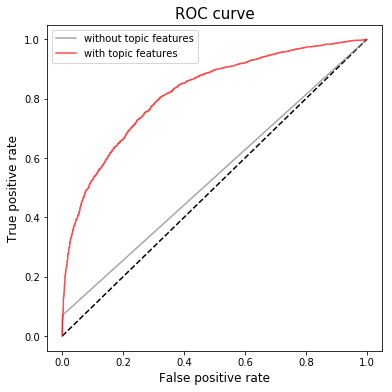

In [130]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='without topic features',c='grey',alpha=.7)
#plt.plot(fpr_nb_lsa, tpr_nb_lsa, label='with review (LSA)')
plt.plot(fpr_grd, tpr_grd, label='with topic features',c='red',alpha=.7)##941717


plt.xlabel('False positive rate',fontsize='12')
plt.ylabel('True positive rate',fontsize='12')
plt.title('ROC curve', fontsize='15')
plt.legend(loc='best')
plt.savefig('ROC.png', dpi=500);

## Balanced data

In [84]:
g = text_feature_merged.groupby('incentivized')
subset=g.apply(lambda x: x.sample((g.size().min())))

In [85]:
y_s = subset['incentivized']
X_s = mapper_merged.fit_transform(subset)
X_strain, X_stest, y_strain, y_stest = train_test_split(X_s, y_s, test_size=0.4,random_state=42)

In [86]:
nb = GaussianNB()
nb.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, nb.predict(X_strain)))
print(roc_auc_score(y_stest, nb.predict(X_stest)))
y_pred_nb = nb.predict_proba(X_stest)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_stest, y_pred_nb)

0.7000287393598351
0.6986496317847649


In [725]:
print(recall_score(y_test_nt,nb_nt.predict(X_test_nt)))
print(classification_report(y_test_nt,nb_nt.predict(X_test_nt)))

0.2515437114072148
             precision    recall  f1-score   support

          0       0.94      0.91      0.93     41040
          1       0.17      0.25      0.21      3077

avg / total       0.89      0.86      0.88     44117



In [726]:
print(recall_score(y_test_mg,gradboost.predict(X_test_mg)))
print(classification_report(y_test_mg,gradboost.predict(X_test_mg)))

0.7648394421018488
             precision    recall  f1-score   support

          0       0.98      0.71      0.83     40801
          1       0.17      0.76      0.28      3083

avg / total       0.92      0.72      0.79     43884



In [89]:
gradboost =GradientBoostingClassifier()
gradboost.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, gradboost.predict(X_strain)))
print(roc_auc_score(y_stest, gradboost.predict(X_stest)))
y_pred_grd = gradboost.predict_proba(X_stest)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_stest, y_pred_grd)

0.7581103398665422
0.7381132955279804


In [294]:
from sklearn.metrics import f1_score
f1_score(y_stest,gradboost.predict(X_stest))  

0.7507323907782448

In [101]:
randomforest = RandomForestClassifier(n_estimators=80,max_depth=10,max_features= 'sqrt',random_state=42)
randomforest.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, randomforest.predict(X_strain)))
print(roc_auc_score(y_stest, randomforest.predict(X_stest)))

0.8093572447000787
0.7420003191574243


In [260]:
importance=list(gradboost.feature_importances_)

In [105]:
columns=['rating','helpfulness','n_reviews','productprice','vib','age_13to17','age_18to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_over54',
        'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5',
       'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23','feat_24',
          'sent_neg', 'sent_neu', 'sent_pos']

In [261]:
zipped=dict(zip(columns,importance))
fi = pd.DataFrame().append(zipped, ignore_index=True).T.sort_values(by=0,ascending=False)

In [262]:
list(fi[0])

[0.17426821516736443,
 0.11294665233279795,
 0.0995381502339846,
 0.08013832375241035,
 0.06120252768544896,
 0.056926593005595244,
 0.05196173521513145,
 0.04538045835121483,
 0.02820757787837054,
 0.02506646909635867,
 0.020452273252004917,
 0.02039264337720127,
 0.017627214501763817,
 0.016540304981614556,
 0.016345926581762427,
 0.015513298529321075,
 0.014145089133912743,
 0.013795507001755296,
 0.012347549855075886,
 0.011923844799411418,
 0.011148879300795363,
 0.010092739540837782,
 0.009968079352054814,
 0.008667291493096403,
 0.0082284290829918,
 0.007478650170705299,
 0.00681327593966739,
 0.00573790522359366,
 0.00548825226491564,
 0.005217945507306959,
 0.005207359677985591,
 0.00519347380108646,
 0.004273126492009102,
 0.003941196643380096,
 0.0024060330435444048,
 0.0020405744658756535,
 0.001904390105554061,
 0.0014720431620990114,
 0.0]

In [263]:
fi.columns=['importance']

In [264]:
fi

,importance
productprice,0.174268
feat_15,0.112947
vib,0.099538
n_reviews,0.080138
sent_neu,0.061203
sent_neg,0.056927
sent_pos,0.051962
helpfulness,0.045380
age_25to34,0.028208
feat_23,0.025066


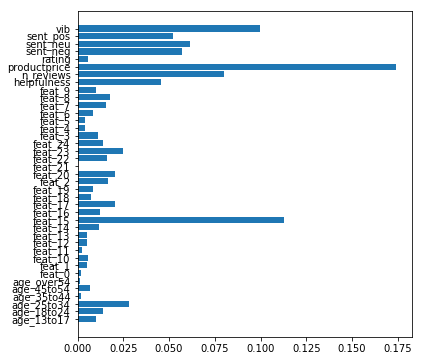

In [269]:
fi = fi.sort_values(by='importance')

In [533]:
from matplotlib import cm

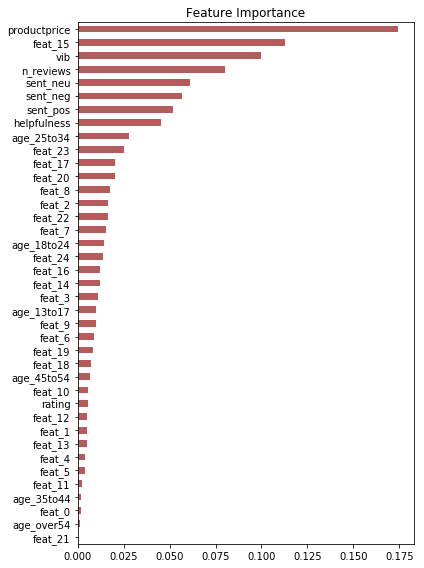

In [551]:

fi.plot(kind='barh',legend=False,figsize=(6,8),title='Feature Importance',fontsize='10',color='#941717',alpha=.7)
plt.tight_layout()
plt.savefig('features.png', dpi=500,pad_inches=None)

In [349]:
reviews_new.columns

Index(['review_id', 'AuthorId', 'IsFeatured', 'IsRatingsOnly', 'IsRecommended',
       'Rating', 'Title', 'ReviewText', 'Helpfulness', 'product_id',
       'productPrice', 'incentivized', 'age', 'vib', 'n_reviews',
       'complimentary', 'sent_compound', 'sent_neg', 'sent_neu', 'sent_pos'],
      dtype='object')

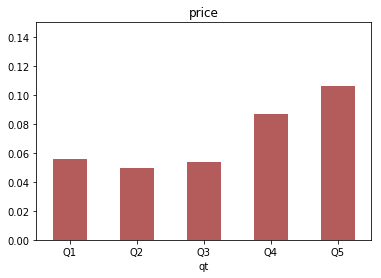

In [696]:
def bar_quartile(var, label, r, c):
    df = reviews_new.loc[:,['incentivized',var]]
    df['qt'] = pd.qcut(reviews_new[var],5,labels=["Q1", "Q2", "Q3","Q4","Q5"])

    return df.groupby('qt').incentivized.value_counts(normalize =True).unstack()[1].plot.bar(color='#941717',legend=False,title=label,ylim=(0,.15), rot=0, alpha=.7 );


bar_quartile('productPrice','price',0,0);

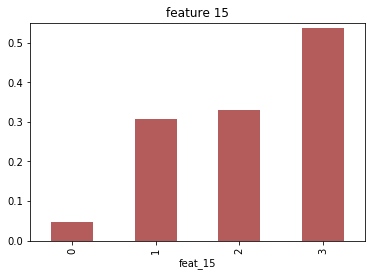

In [697]:
text_feature_merged.groupby('feat_15').incentivized.value_counts(normalize =True).unstack()[1].plot.bar(color='#941717',
                                                                                        legend=False,title='feature 15',ylim=(0,.55),alpha=.7);

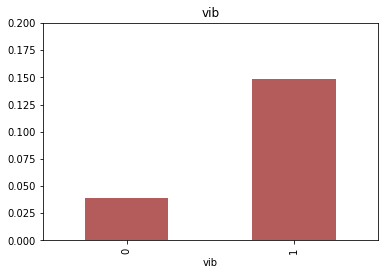

In [698]:
text_feature_merged.groupby('vib').incentivized.value_counts(normalize =True).unstack()[1].plot.bar(color='#941717',
                                                                                        legend=False,title='vib',ylim=(0,.2),alpha=.7);

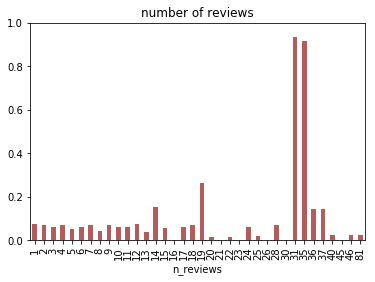

In [704]:
text_feature_merged.groupby('n_reviews').incentivized.value_counts(normalize =True).unstack()[1].plot.bar(color='#941717',
                                                                                        legend=False,title='number of reviews',ylim=(0,1),alpha=.7);

In [ ]:
# plt.figure(figsize=(6,6))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_grd, tpr_grd, label='GBT')
# plt.plot(fpr_nb, tpr_nb, label='NB')
# plt.xlabel('False positive rate',fontsize='12')
# plt.ylabel('True positive rate',fontsize='12')
# plt.title('ROC curve with features from text', fontsize='15')
# plt.legend(loc='best');
#plt.savefig('ROC.png', dpi=500);

## LSA

In [144]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer

In [150]:
review_list=list(df['ReviewText'])

In [151]:
vectorizer = CountVectorizer(min_df = 4, strip_accents='ascii',stop_words = 'english')
dtm = vectorizer.fit_transform(review_list)  # dtm: Document-Term Matrix
pd.DataFrame(dtm.toarray(), index=review_list, columns=vectorizer.get_feature_names()).head(10)

,00,000,00am,01,02,03,04,05,06,07,...,zip,ziploc,ziplock,zit,zits,zitty,zombie,zone,zones,zoo
"I tried ItCosmetics about a year ago and loved the foundation and concealer, and bye bye pore powder. Of course I had to try the cc cream and just as with all other ItCosmetics products I love it . During the summer I like having something light on my skin that won't melt away and look oily . This product has given me everything I asked for . I have also used it as a primer before applying a light foundation and it works beautifully. Truly recommend it",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I've purchased hundreds of items from Sephora but have never gone out of my way to write a review. This is the BEST cc cream I've ever used. I've been a long time user of Laura Mercier tinted moisturizer but have been on the search for a cream with more coverage that I can wear on it's own. This is THE BEST. I have really red cheeks and this completely evens out my skin tone and has super smooth, beautiful coverage. I've been wearing tinted moisturizer powder every day for years, and so happy to finally feel confident enough to wear just the cc cream and cut out a step in my beauty routine! So happy my hunt for the perfect cream is over!",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I'm obsessed with taking care of my skin and I've been trying to use less foundation and makeup. \nJust a tiny dot of this (because otherwise it's too thick and the color won't blend out into the skin well) and I mix it with my moisturizer. I've gotten so many compliments on my complexion since I've used this. This is definitely for when you want a very natural look / easy light makeup,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"This is the only ""foundation"" ive ever bought a second tube of!! I was always unsatisfied about the ones i used before, they were too dry, or made me break out, or just weren't all that suitable to my extremely sensitive skin. I live the dewy look that gives to my skin! I always get compliments when i use this.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I have to use 6 blottung sheets after using this,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I absolutely love this cc cream! I have hyper pigmentation in my cheeks, and this baby cancels it out after only one layer! If you're looking for a great, natural looking foundation/cc cream, this is the one for you! You can either keep it looking like your skin but better with only one layer, or build it up to achieve that super full coverage look. It has a bit of a citrus scent, but isn't that noticeable once on your skin. The cc cream is so easy to blend and protects my skin since it has an SPF of 50! It does not break me out, unlike most foundations. This cc cream has exceeded my expectations and I will definitely repurchase it once I'm at out!",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I love love love love love this foundation. It's so moisturizing and does wonders for my skin. However, I hate that it has very few shade options, and it doesn't last all day. However, I still use this as my everyday foundation, because I'm prone to breakouts on my sensitive skin if I use something too heavy. Would definitely recommend someone that is within the shade range.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I have dry skin that tends to have flaky patches during winter months, so naturally I figured this would be great to help keep my parched skin hydrated while looking great with SPF protection. I couldn't have been more wrong. This product is beyond disappointing, it's way too shimmery and shiny and makes my face look greasy. The color range is limited and the so called yellow undertones in this made my skin look gray. It did nothing to moisturize my skin and finally it made me break out. I will be returning this.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
This product does what it says. It really brightens the under eye but it is so hard to work with. If it's not warm it doesn't blend 

In [153]:
lsa = TruncatedSVD(25, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)

In [154]:
pd.DataFrame(lsa.components_.round(5),index = ["component_1","component_2","component_3","component_4",
                                              "component_5","component_6","component_7","component_8",
                                              "component_9","component_10",
                                              "component_11","component_12","component_13","component_14",
                                              "component_15","component_16","component_17","component_18",
                                              "component_19","component_20","component_21","component_22",
                                               "component_23","component_24","component_25"],
             columns = vectorizer.get_feature_names())['sample']

component_1     0.05019
component_2     0.03444
component_3    -0.02446
component_4     0.01460
component_5     0.01618
component_6    -0.05335
component_7    -0.04154
component_8    -0.03133
component_9    -0.04655
component_10   -0.02693
component_11   -0.02591
component_12    0.06021
component_13   -0.10085
component_14    0.01942
component_15    0.12611
component_16   -0.06841
component_17   -0.29253
component_18   -0.01920
component_19   -0.18481
component_20   -0.08002
component_21    0.14898
component_22    0.18147
component_23    0.35425
component_24    0.20499
component_25   -0.01498
Name: sample, dtype: float64

In [155]:
LSA_matrix=pd.DataFrame(dtm_lsa.round(5), index = review_list, 
             columns = ["component_1","component_2","component_3","component_4",
                                              "component_5","component_6","component_7","component_8",
                                              "component_9","component_10",
                       "component_11","component_12","component_13","component_14",
                                              "component_15","component_16","component_17","component_18",
                                              "component_19","component_20","component_21","component_22",
                                               "component_23","component_24","component_25"])

In [156]:
LSA_matrix['review_id']=list(df['review_id'])

In [157]:
LSA_matrix['incentivized']=list(df['incentivized'])

In [158]:
observations_lsa=reviews_new[['review_id','Rating','Helpfulness','n_reviews','productPrice',
                           'age','vib','sent_compound','sent_neg','sent_neu','sent_pos']]

In [159]:
observations_lsa=observations_lsa.merge(LSA_matrix,how='inner',on='review_id')

In [160]:
observations_lsa.shape

(110292, 37)

In [161]:
observations_lsa = pd.get_dummies(observations_lsa, columns=['age'])

In [162]:
mapper_lsa = DataFrameMapper([
        (['Rating','Helpfulness','n_reviews','productPrice'], [Imputer(strategy='median'),StandardScaler()]),
        (['vib','component_1', 'component_2', 'component_3', 'component_4',
       'component_5', 'component_6', 'component_7', 'component_8',
       'component_9', 'component_10'],None),
         (['age_13to17','age_18to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_over54', 'age_unknow',
           'sent_neg', 'sent_neu', 'sent_pos'], None)#[Imputer(),StandardScaler()])
])


In [340]:
g_lsa= observations_lsa.groupby('incentivized')
subset_lsa=g_lsa.apply(lambda x: x.sample((g_lsa.size().min())))

In [341]:
y_lsa =subset_lsa['incentivized']
X_lsa=mapper_lsa.fit_transform(subset_lsa)

In [342]:
X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, y_lsa, test_size=0.5, random_state=3)

In [428]:
nb_lsa = GaussianNB()
nb_lsa.fit(X_train_lsa, y_train_lsa)
print(roc_auc_score(y_train_lsa, nb_lsa.predict(X_train_lsa)))
print(roc_auc_score(y_test_lsa, nb_lsa.predict(X_test_lsa)))
y_pred_lsa = nb_lsa.predict_proba(X_test_lsa)[:, 1]
fpr_nb_lsa, tpr_nb_lsa, _ = roc_curve(y_test_lsa, y_pred_lsa)

0.6926288742572668
0.6877239275014813


# LDA

In [ ]:
nltk.download('stopwords')

In [ ]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
with open('review_list.pickle', 'wb') as handle:
    pickle.dump(review_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(review_list))

print(data_words[:1])

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[data_words[0]])

In [168]:
table=pd.read_pickle('lda_table.pickle')

In [169]:
table.columns=[ 'topic 0','topic 1','topic 2','topic 3','topic 4','topic 5','topic 6','topic 7','topic 8',
               'topic 9','topic 10','topic 11','topic 12','topic 13','topic 14',
               'topic 15','topic 16','topic 17','topic 18','topic 19',
                'review_id', 'incentivized']

In [170]:
observations_lda=reviews_new[['review_id','Rating','Helpfulness','n_reviews','productPrice',
                           'age','vib','sent_compound','sent_neg','sent_neu','sent_pos']]

In [171]:
observations_lda=observations_lda.merge(table,how='inner',on='review_id')

In [172]:
observations_lda = pd.get_dummies(observations_lda, columns=['age'])

In [173]:
observations_lda.columns

Index(['review_id', 'Rating', 'Helpfulness', 'n_reviews', 'productPrice',
       'vib', 'sent_compound', 'sent_neg', 'sent_neu', 'sent_pos', 'topic 0',
       'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6',
       'topic 7', 'topic 8', 'topic 9', 'topic 10', 'topic 11', 'topic 12',
       'topic 13', 'topic 14', 'topic 15', 'topic 16', 'topic 17', 'topic 18',
       'topic 19', 'incentivized', 'age_18to24', 'age_25to34', 'age_35to44',
       'age_unknow'],
      dtype='object')

In [174]:
mapper_lda = DataFrameMapper([
        (['Rating','Helpfulness','n_reviews','productPrice'], [Imputer(strategy='median'),StandardScaler()]),
        (['vib','topic 0',
       'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6',
       'topic 7', 'topic 8', 'topic 9', 'topic 10', 'topic 11', 'topic 12',
       'topic 13', 'topic 14', 'topic 15', 'topic 16', 'topic 17', 'topic 18',
       'topic 19'],None),
         (['age_18to24',
       'age_25to34', 'age_35to44', 'age_unknow',
           'sent_neg', 'sent_neu', 'sent_pos'], None)#[Imputer(),StandardScaler()])
])

In [175]:
y_lda =observations_lda['incentivized']
X_lda=mapper_lda.fit_transform(observations_lda)

In [176]:
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y_lda, test_size=0.5,random_state=42)

In [177]:
nb = GaussianNB()
nb.fit(X_train_lda, y_train_lda)
print(roc_auc_score(y_train_lda, nb.predict(X_train_lda)))
print(roc_auc_score(y_test_lda, nb.predict(X_test_lda)))
y_pred_lda = nb.predict_proba(X_test_lda)[:, 1]
fpr_nb_lda, tpr_nb_lda, _ = roc_curve(y_test_lda, y_pred_lda)

0.7574679943100995
0.4984681037312616


In [178]:
gradboost =GradientBoostingClassifier()
gradboost.fit(X_train_lda, y_train_lda)
print(roc_auc_score(y_train_lda, gradboost.predict(X_train_lda)))
print(roc_auc_score(y_test_lda, gradboost.predict(X_test_lda)))
y_pred_grd = gradboost.predict_proba(X_test_lda)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test_lda, y_pred_lda)

1.0
0.523197286355181


## Regression model

In [ ]:
y =all_feature_columns['incentivized']
X=all_feature_columns.iloc[:,:25]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print(roc_auc_score(y_train, nb.predict(X_train)))
print(roc_auc_score(y_test, nb.predict(X_test)))


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_X_train=pca.fit_transform(X_train)
pca_X_test=pca.transform(X_test)



In [ ]:
nb.fit(pca_X_train, y_train)
roc_auc_score(y_test, nb.predict(pca_X_test))

In [ ]:
logreg = LogisticRegression()
logreg.fit(pca_X_train, y_train)
print(roc_auc_score(y_train, logreg.predict(pca_X_train)))
print(roc_auc_score(y_test, logreg.predict(pca_X_test)))

In [ ]:
randomforest = RandomForestClassifier(n_estimators=80,max_depth=10)
randomforest.fit(pca_X_train, y_train)
print(roc_auc_score(y_train, randomforest.predict(pca_X_train)))
print(roc_auc_score(y_test, randomforest.predict(pca_X_test)))

In [ ]:
gradboost =GradientBoostingClassifier()
gradboost.fit(X_train, y_train)
print(roc_auc_score(y_train, gradboost.predict(X_train)))
print(roc_auc_score(y_test, gradboost.predict(X_test)))

## Combine review table

In [ ]:
reviews_new.columns

In [ ]:
reviews_model=reviews_new[['AuthorId', 'IsFeatured', 'IsRatingsOnly', 'IsRecommended', 'Rating',
                       'ReviewText','Helpfulness', 'product_id', 'productPrice', 'incentivized', 'age',
       'vib', 'review_id']]

In [ ]:
reviews_model['n_reviews']=reviews_model['review_id'].groupby(reviews_model['AuthorId']).transform('count')
reviews_model['Helpfulness']=reviews_model['Helpfulness'].fillna(0)
reviews_model['productPrice']=reviews_model['productPrice'].apply(lambda x: float(x))
reviews_model['vib']=reviews_model['vib'].apply(lambda x: 0 if x=='no' or x=='unknow' else 1)

In [ ]:
reviews_model.info()

In [ ]:
observations=reviews_model[['review_id','Rating','Helpfulness','n_reviews','productPrice',
                           'age','vib','sent_compound','sent_neg','sent_neu','sent_pos']]
observations = pd.get_dummies(observations, columns=['age'])
observations.columns = list(map(lambda x: x.lower().replace(' ', '_').replace('/', '_').replace('__','_'), observations.columns))

In [ ]:
observations=observations.merge(all_feature_columns,how='inner',on='review_id')

In [ ]:
observations.info()

In [ ]:
observations.columns

In [ ]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper, CategoricalImputer
mapper = DataFrameMapper([
        (['rating','helpfulness','n_reviews','productprice'], [Imputer(strategy='median'),StandardScaler()]),
        (['vib','feat_0', 'feat_1',
       'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8',
       'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14',
       'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 
        'feat_22', 'feat_23', 'feat_24'],None),
         (['age_13to17','age_18to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_over54', 'age_unknow',
           'sent_neg', 'sent_neu', 'sent_pos'], None)#[Imputer(),StandardScaler()])
])
       

In [ ]:
y =observations['incentivized']

X=mapper.fit_transform(observations)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
nb = GaussianNB()
nb.fit(X_train, y_train)
print(roc_auc_score(y_train, nb.predict(X_train)))
print(roc_auc_score(y_test, nb.predict(X_test)))

In [ ]:
X.shape

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(roc_auc_score(y_train, logreg.predict(X_train)))
print(roc_auc_score(y_test, logreg.predict(X_test)))

In [ ]:
gradboost =GradientBoostingClassifier()
gradboost.fit(X_train, y_train)
print(roc_auc_score(y_train, gradboost.predict(X_train)))
print(roc_auc_score(y_test, gradboost.predict(X_test)))

In [ ]:
## Balanced data

In [ ]:
g = observations.groupby('incentivized')
subset=g.apply(lambda x: x.sample((g.size().min())))

In [ ]:
subset.shape

In [ ]:
y_s = subset['incentivized']
X_s = mapper.fit_transform(subset)
X_strain, X_stest, y_strain, y_stest = train_test_split(X_s, y_s, test_size=0.5,random_state=42)
nb = GaussianNB()
nb.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, nb.predict(X_strain)))
print(roc_auc_score(y_stest, nb.predict(X_stest)))
gradboost =GradientBoostingClassifier()
gradboost.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, gradboost.predict(X_strain)))
print(roc_auc_score(y_stest, gradboost.predict(X_stest)))

In [ ]:
nb = GaussianNB()
nb.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, nb.predict(X_strain)))
print(roc_auc_score(y_stest, nb.predict(X_stest)))

In [ ]:
gradboost =GradientBoostingClassifier()
gradboost.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, gradboost.predict(X_strain)))
print(roc_auc_score(y_stest, gradboost.predict(X_stest)))

In [ ]:
vectors=pd.DataFrame(sentence_word_vectors_truncated)

In [ ]:
vectors['incentivized']=list(df_sentence_product['incentivized'])

In [ ]:
y =vectors['incentivized']
X=vectors.iloc[:,:300]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print(roc_auc_score(y_train, nb.predict(X_train)))
print(roc_auc_score(y_test, nb.predict(X_test)))

In [ ]:
g_v = vectors.groupby('incentivized')
subset=g_v.apply(lambda x: x.sample((g_v.size().min())))

In [ ]:
y_s =subset['incentivized']
X_s=subset.iloc[:,:300]

In [ ]:
X_strain, X_stest, y_strain, y_stest = train_test_split(X_s, y_s, test_size=0.5, random_state=3)

In [ ]:
nb = GaussianNB()
nb.fit(X_strain, y_strain)
print(roc_auc_score(y_strain, nb.predict(X_strain)))
print(roc_auc_score(y_stest, nb.predict(X_stest)))